In [1]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from geopy.distance import geodesic
from sklearn.cluster import KMeans
# from datetime import datetime
# from timezonefinder import TimezoneFinder
# from pytz import timezone

# Calculate distance from home function
def calculate_distance(row):
    home_location = (row['lat'], row['long'])
    merch_location = (row['merch_lat'], row['merch_long'])
    return geodesic(home_location, merch_location).miles

# Function to calculate the Haversine distance
# def haversine_distance(lat1, lon1, lat2, lon2):
#     R = 6371  # Earth radius in kilometers
    
#     # Convert degrees to radians
#     lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
#     # Difference in coordinates
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
    
#     # Haversine formula
#     a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
#     c = 2 * np.arcsin(np.sqrt(a))
    
#     # Distance in kilometers
#     distance = R * c
#     return distance

# Function to calculate distance between two points
def calculate_distance2(row1, row2):
    point1 = (row1['lat'], row1['long'])
    point2 = (row2['lat'], row2['long'])
    return geodesic(point1, point2).miles

# # Function to get timezone from latitude and longitude
# def get_timezone_from_lat_long(lat, long):
#     tf = TimezoneFinder()
#     return tf.timezone_at(lat=lat, lng=long)  # Finds the timezone string

# def convert_utc_to_local(utc_dt, lat, long):
#     tz_name = get_timezone_from_lat_long(lat, long)
#     tz = timezone(tz_name)
#     return utc_dt.astimezone(tz)


def process(df):
    # Add new features
    # Rearrange the rows
    df['original_order'] = range(df.shape[0])

    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')
    df['dob'] = pd.to_datetime(df['dob'], format='%d/%m/%Y')

    # df['timestamp'] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')
    # df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')

    df.sort_values(by=['cc_num', 'trans_date_trans_time'], inplace=True)
    # Calculate time difference in hours
    # df['time_since_last_trans'] = df.groupby('cc_num')['trans_date_trans_time'].diff().apply(lambda x: x.total_seconds() / 3600)
    # # Fill NaN values for each user's first transaction
    # df['time_since_last_trans'] = df['time_since_last_trans'].fillna(value=0)
    # Calculate the time difference between transactions
    df['Time_Delta'] = df.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds() / 60.0  # Time delta in minutes
    df['Time_Delta'] = df['Time_Delta'].fillna(value=0)
    # Calculate the time difference between current and previous transactions in hours
    # df['time_diff_hours'] = df.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds() / 3600
    # df['time_diff_hours'] = df['time_diff_hours'].fillna(0)
    # # Assuming 'Time_Delta' in minutes is already calculated
    #df['Hourly_Freq'] = df.groupby('cc_num').rolling(window='1h', on='trans_date_trans_time', closed='left')['amt'].count()
    # # First, ensure the dataframe is sorted as before
    # #df['count_last_24h'] = df.groupby('cc_num')['trans_date_trans_time'].transform(lambda x: x.diff().rolling('12h').count())
    # # Now, to count transactions in the last 24 hours, we initialize a column for counts
    # df['count_last_12h'] = 0

    # for i in df['cc_num'].unique():
    #     # For each credit card number, iterate over transactions
    #     temp = df[df['cc_num'] == i]  # Temporary DataFrame for each credit card
    #     for j in range(len(temp)):
    #         # Calculate the sum of transactions in the last 24 hours
    #         # This is a naive method, and there are more efficient ways to do this with cumulative sums or using pandas' rolling windows with custom criteria
    #         df.loc[temp.index[j], 'count_last_12h'] = temp.iloc[max(0, j-12):j]['time_diff_hours'].count()


    # Group by 'cc_num' and then apply a rolling count with a 24-hour window, shifted to not include the current transaction
    #df['transaction_frequency_24hr'] = df.groupby('cc_num').rolling(window='24h', on='trans_date_trans_time', closed='left').count()

    # Shift the latitude and longitude to get the previous transaction's location
    df['prev_lat'] = df.groupby('cc_num')['merch_lat'].shift(1)
    df['prev_long'] = df.groupby('cc_num')['merch_long'].shift(1)

    # Calculate the distance to the previous transaction
    df['distance_to_prev'] = df.apply(
        lambda row: calculate_distance2(
            {'lat': row['lat'], 'long': row['long']},
            {'lat': row['prev_lat'], 'long': row['prev_long']}
        ) if not pd.isnull(row['prev_lat']) else None,
        axis=1
    )
    
    df['distance_to_prev'] = df['distance_to_prev'].fillna(value=0)

    # Calculate location consistency as the inverse of the average distance to previous transactions (higher value means more consistency)
    df['location_consistency'] = 100 / df.groupby('cc_num')['distance_to_prev'].transform('mean')

    # Use a rolling window to count distinct merchants for each transaction, excluding the current transaction to avoid lookahead bias
    # df['merchant_variety_24hr'] = df.groupby('cc_num').rolling(window='24h', on='trans_date_trans_time', closed='left')['merchant'].apply(lambda x: x.nunique())

    # Calculate the rolling standard deviation of transaction amounts with a 7-day window for each card
    # df['amount_variability_7days'] = df.groupby('cc_num')['amt'].transform(
    #     lambda x: x.rolling(window='7d', on='trans_date_trans_time').std()
    # )
    
    # Assuming your dataframe is named `data`
    # Convert 'unix_time' to datetime in UTC
    #df['trans_date_trans_time_utc'] = pd.to_datetime(df['unix_time'], unit='s', utc=True)
    # Apply the conversion for each transaction
    # df['local_time'] = df.apply(lambda x: convert_utc_to_local(x['trans_date_trans_time_utc'], x['merch_lat'], x['merch_long']), axis=1)
    # df['local_time'] = pd.to_datetime(df['local_time'])
    # # Extract the hour from 'local_time'
    # df['local_time_hour'] = df['local_time'].dt.hour
    # df['local_day_of_week'] = df['local_time'].dt.dayofweek
    # Time-based features
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek

    # df['trans_hour'] = date_time.dt.hour
    # df['trans_day_of_week'] = date_time.dt.dayofweek
    
    # Age of the account holder
    df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

    # df['trans_dist'] = haversine_distance(df['lat'], df['long'], df['merch_lat'], df['merch_long'])
    df['dist_to_home'] = df.apply(calculate_distance, axis=1)

    # user_avg_amt = df.groupby('cc_num')['amt'].mean().reset_index(name='Avg_Amt')
    # df = df.merge(user_avg_amt, on='cc_num')
    # df['Relative_Amt'] = abs(df['amt'] - df['Avg_Amt']) / df['Avg_Amt']
    # Calculate the historical average transaction amount for each user
    avg_amt_per_user = df.groupby('cc_num')['amt'].transform('mean').rename('avg_amt_per_user')

    # Append this feature to the dataset
    df['amt_relative_avg'] = df['amt'] / avg_amt_per_user
    #df['relative_amt'] = abs(df['amt'] - avg_amt_per_user) / avg_amt_per_user

    kmeans = KMeans(n_clusters=5, random_state=42)

    # Create a new column for the cluster labels
    df['city_pop_cluster'] = kmeans.fit_predict(df[['city_pop']])
    
    print("Cluster Centers (Population):", kmeans.cluster_centers_)



    df.drop(columns=['trans_date_trans_time', 'lat', 'long', 'merch_lat', 'merch_long'], inplace=True)
    df.drop(columns=['prev_lat', 'prev_long', 'cc_num'], inplace=True)

    # Identify categorical columns to encode
    categorical_cols = ['merchant', 'category', 'gender', 'city', 'state', 'job']

    mappings = {}

    label_encoder = LabelEncoder()
    for col in categorical_cols:
        df[col] = label_encoder.fit_transform(df[col])
        mappings[col] = {label: index for index, label in enumerate(label_encoder.classes_)}

    # Sort the dataset back to its original order
    df.sort_values(by='original_order', inplace=True)
    df.drop(columns='original_order', inplace=True)

    return df, mappings

trainingSet = pd.read_csv("./data/train.csv")
submissionSet = pd.read_csv("./data/test.csv")
train_processed, cat_map = process(trainingSet)
train_processed.drop(columns=['first', 'last', 'street', 'dob', 'zip', 'trans_num', 'unix_time'], inplace=True)

# Merge on Id so that the test set can have feature columns as well
test_df = pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
test_df = test_df.drop(columns=['is_fraud_x'])
test_df = test_df.rename(columns={'is_fraud_y': 'is_fraud'})

# The training set is where the score is not null
train_df = train_processed[train_processed['is_fraud'].notnull()]

# Save the datasets with the new features for easy access later
test_df.to_csv("./data/test_p.csv", index=False)
train_df.to_csv("./data/train_p.csv", index=False)


ValueError: cannot handle a non-unique multi-index!

In [16]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# Assuming 'train_df' includes both features and the target ('is_fraud')
X = train_df.drop(['is_fraud', 'Id', 'city_pop'], axis=1)
y = train_df['is_fraud']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

train_df = pd.read_csv("./data/train_processed4.csv")
test_df = pd.read_csv("./data/test_processed4.csv")
test_df = test_df.drop(['cc_num', 'location_consistency'], axis=1)
# scaled_cols = ['city_pop']
# # Initialize the StandardScaler
# scaler = StandardScaler()
# # Fit on the training set and transform both training and validation sets
# train_df[scaled_cols] = scaler.fit_transform(train_df[scaled_cols])

# Assuming 'train_df' includes both features and the target ('is_fraud')
X = train_df.drop(['is_fraud', 'Id', 'cc_num', 'location_consistency'], axis=1)
y = train_df['is_fraud']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


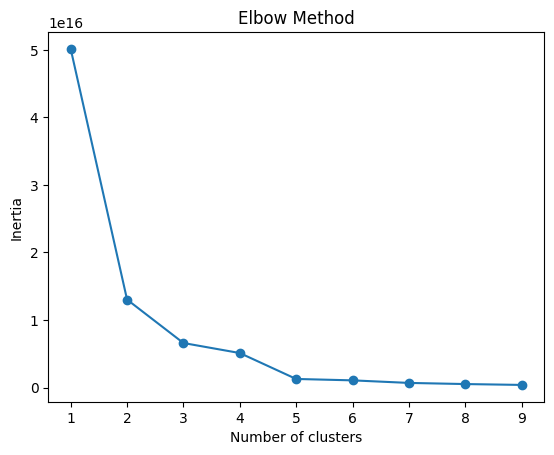

In [2]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from geopy.distance import geodesic
from sklearn.cluster import KMeans
trainingSet = pd.read_csv("./data/train.csv")

city_pop = trainingSet[['city_pop']]
inertia = []
for n in range(1, 10):
    kmeans = KMeans(n_clusters=n, random_state=42).fit(city_pop)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



In [8]:
# Replace `3` with your chosen number of clusters
kmeans = KMeans(n_clusters=5, random_state=42).fit(city_pop)

# Create a new column for the cluster labels
d = pd.DataFrame(kmeans.labels_, columns=['city_pop_cluster'])
#print(kmeans.labels_)


In [17]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 389003 entries, 303198 to 254010
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   merchant              389003 non-null  int64  
 1   category              389003 non-null  int64  
 2   amt                   389003 non-null  float64
 3   gender                389003 non-null  int64  
 4   city                  389003 non-null  int64  
 5   state                 389003 non-null  int64  
 6   job                   389003 non-null  int64  
 7   Time_Delta            389003 non-null  float64
 8   distance_to_prev      389003 non-null  float64
 9   location_consistency  389003 non-null  float64
 10  hour                  389003 non-null  int32  
 11  day_of_week           389003 non-null  int32  
 12  age                   389003 non-null  int64  
 13  dist_to_home          389003 non-null  float64
 14  amt_relative_avg      389003 non-null  float64
 15  

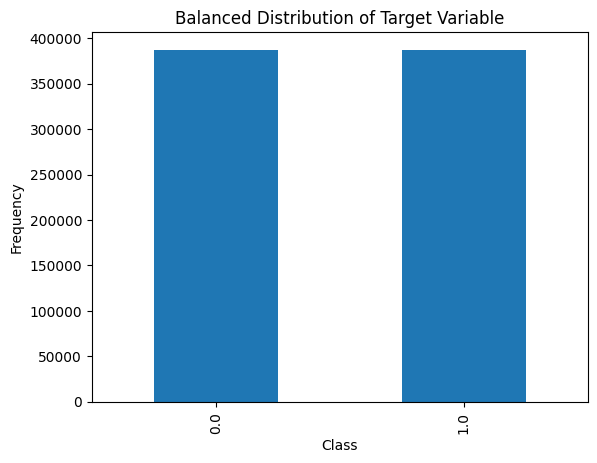

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775002 entries, 0 to 775001
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   merchant          775002 non-null  int64  
 1   category          775002 non-null  int64  
 2   amt               775002 non-null  float64
 3   gender            775002 non-null  int64  
 4   city              775002 non-null  int64  
 5   state             775002 non-null  int64  
 6   city_pop          775002 non-null  int64  
 7   job               775002 non-null  int64  
 8   Time_Delta        775002 non-null  float64
 9   distance_to_prev  775002 non-null  float64
 10  hour              775002 non-null  int64  
 11  day_of_week       775002 non-null  int64  
 12  age               775002 non-null  int64  
 13  dist_to_home      775002 non-null  float64
 14  amt_relative_avg  775002 non-null  float64
dtypes: float64(5), int64(10)
memory usage: 88.7 MB
None


In [8]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Plot the balanced distribution
pd.Series(y_train_balanced).value_counts().plot(kind='bar')
plt.title('Balanced Distribution of Target Variable')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

print(X_train_balanced.info())


In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pickle

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Parameters for GridSearchCV
param_grid = {
    'max_depth': [None, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [2, 4, 8, 10],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='f1_micro', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Validation
best_dt = grid_search.best_estimator_

# with open('dt_model4.obj', 'wb') as f:
#     pickle.dump(best_dt, f)


y_pred_dt = best_dt.predict(X_val)

val_f1 = f1_score(y_val, y_pred_dt)

print(best_params, best_score, val_f1)
print(classification_report(y_val, y_pred_dt))

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   3.3s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5; total time=   3.3s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   3.8s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   4.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5; total time=   4.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   4.3s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5; total time=   4.3s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   4.6s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5; total time=   4.6s
[CV] END criterion=gini, max

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END criterion=gini, max_depth=None, min_samples_leaf=10, min_samples_split=2; total time=   4.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=10, min_samples_split=5; total time=   3.8s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=10, min_samples_split=5; total time=   3.8s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=10, min_samples_split=5; total time=   4.3s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=10, min_samples_split=5; total time=   4.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=10, min_samples_split=5; total time=   4.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=10, min_samples_split=10; total time=   3.8s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=10, min_samples_split=10; total time=   4.3s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=10, min_samples_split=10; total time=   4.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=10, min_samples_split